You can perform PID on MI(r;(x,v)), and compare the result of different 'x'.<br>
'x' can from experimental data or produce in this code for different Tau (Gramma) or cutoff frequency.<br>
'r' can be real responses of RGC or from NGD or from x+$\Delta$*v.<br>
Using 20200408 Chou's data, unit2.<br>

# Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib.ticker import MaxNLocator
import math
from scipy import signal
from scipy.fftpack import fft
from scipy import ndimage
from scipy.io import loadmat
import os
%matplotlib inline

In [2]:
# import import_ipynb
# try:
#     os.chdir('C:\\Users\\hydro_leo\\Documents\\GitHub\\python-code\\Modules')
# except:
#     os.chdir('C:\\Users\\llinc\\GitHub\\python-code\\Modules')
# from StimulusnResponse import expSnR
# from StimulusnResponse import SSG

def SSG(Fc_list, dt, tot, tau = 1, D = 1):
    T = np.arange(0,tot,dt)
    # OU ; input
    OU=np.zeros(len(T))
    mu, sigma = 0, 1
    for i in range(len(T)-1):
        OU[i+1]=OU[i]*(1-dt/tau)+np.sqrt(D*dt)*np.random.normal(mu,sigma)
    # filtering for OUSmoothed
    
    LPOU_list = []
    for Fc in Fc_list:
        b, a = signal.butter(2, 2*Fc*dt, btype='low', analog=False)
        LPOU_list.append(signal.filtfilt(b, a, OU))
    LPOU_list.append(OU)
    return LPOU_list

In [3]:
def TemporalKernelInput(I, K, dt):
    nK = np.append(np.zeros(len(K)-1),K)
    if len(nK) > len(I):
        print('input too short')
        return np.nan
    else:
        return np.convolve(I, nK, 'same')*dt

# Load Experimental data

## select files and channels

In [4]:
# Fc_list = [2, 4, 7, 10]
# filenames = ['D:\\GoogleDrive\\retina\\Chou\'s data\\20200408\\20200408_OU_cutoff='+str(Fc)+'_sort_unit2' for Fc in Fc_list]
# dt = 0.01
# x_list, T_list, rstate_list = expSnR(filenames, dt, 'LED', [53])
# for i in range(len(x_list)):
#     rstate_list[i] = rstate_list[i][53-1,:]

In [5]:
dt = 0.001
tot = 100
x_list = SSG([1, 3.5], dt, tot)
Taxis = np.arange(0,tot,dt)

# x = np.random.randn(len(T_list[i]))

In [6]:
i = 1
x = x_list[i]
# Taxis = T_list[i]

# DrinnenbergAdaptation+NGD

In [7]:
C_tau_y = 0.025 #s
C_tau_z = 0.25 #s
gamma = 0.7
I = np.zeros_like(x_list[0])
Ttemp = np.arange(0,int(C_tau_y/dt*15))*dt
C_Ky = Ttemp/C_tau_y /C_tau_y *np.exp(-Ttemp/C_tau_y)
Ttemp = np.arange(0,int(min(C_tau_z/dt*8,len(I)/2)))*dt
C_Kz = gamma*Ttemp/C_tau_y /C_tau_y *np.exp(-Ttemp/C_tau_y)+(1-gamma)*Ttemp/C_tau_z /C_tau_z *np.exp(-Ttemp/C_tau_z)

In [8]:
x = (x-np.mean(x))/5+1 #basis: mean = 1, std = 0.2
# x = np.zeros_like(x)
# x[40000:42000]=1
sy = TemporalKernelInput(x, C_Ky, dt)
sz = TemporalKernelInput(x, C_Kz, dt)

In [9]:
alpha = 20. #1/sec
beta =  1.2
K = 23.
g = 40.
phi = 1

alpha_c = -1
alpha_h = g*K
test = 1
tau_c = 1/alpha
tau_h = 1/beta
beta_c = 0.02
beta_h = 20
cone_list = []
horizontal_list = []
s1_list = []

Lum_list = 10**np.arange(-1,3.5,0.5)
for Lum in Lum_list:
    s1 = sy*Lum
    s2 = sz*Lum
    cone = np.zeros(len(Taxis))
    horizontal = np.zeros(len(Taxis))
    for j in range(len(Taxis)-1):
        dc = dt*(-(1+beta_c*s2[j])*(cone[j]/tau_c+test*horizontal[j]) + alpha_c*s1[j])
        dh = dt*(-(1+beta_h*cone[j])*horizontal[j]/tau_h + alpha_h*cone[j])
        cone[j+1] = cone[j]+dc
        horizontal[j+1] = horizontal[j]+dh
    cone_list.append(cone.copy())
    horizontal_list.append(horizontal.copy())

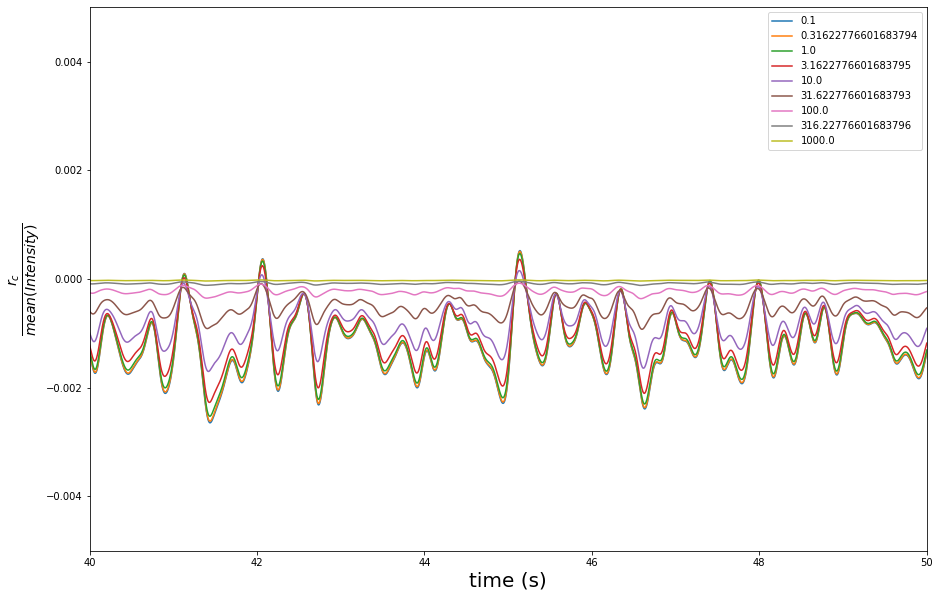

In [10]:
# plt.plot(x*alpha_c)
# plt.plot(sy*alpha_c)
for L in range(len(Lum_list)):
    plt.plot(Taxis, cone_list[L]/Lum_list[L], label = str(Lum_list[L]))
plt.ylabel(r'$\frac{r_c}{mean(Intensity)}$', fontsize = 20)
plt.xlabel('time (s)', fontsize = 20)
plt.xlim([40, 50])
plt.ylim([-0.005, 0.005])
# plt.ylim([-0.05, 0.])
plt.legend(loc='best')
plt.gcf().set_size_inches(15, 10)

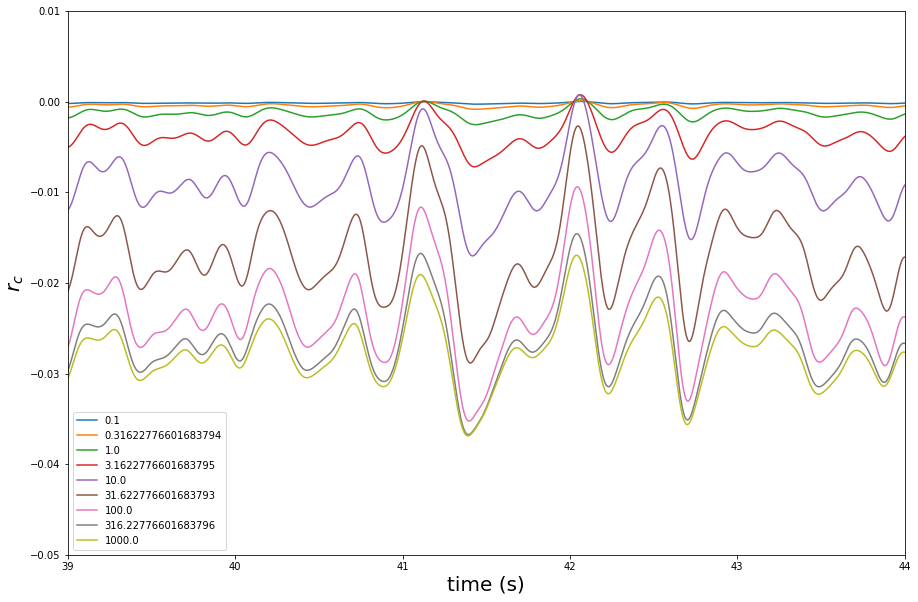

In [24]:
# plt.plot(x*alpha_c)
# plt.plot(sy*alpha_c)
for L in range(len(Lum_list)):
    plt.plot(Taxis, cone_list[L], label = str(Lum_list[L]))
plt.ylabel(r'$r_c$', fontsize = 20)
plt.xlabel('time (s)', fontsize = 20)
plt.xlim([39, 44])
# plt.ylim([-0.005, 0.005])
plt.ylim([-0.05, 0.01])
plt.legend(loc='best')
plt.gcf().set_size_inches(15, 10)

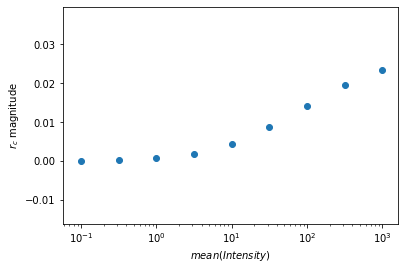

In [12]:
plt.scatter(Lum_list, np.std(np.array(cone_list), axis = 1))
plt.ylabel(r'$r_c$ magnitude')
plt.xlabel(r'$mean(Intensity)$')
plt.xscale('log')

In [13]:
baseXcor_list = [np.correlate(cone_list[0], cone_list[L], 'same')/np.std(cone_list[L]) for L in range(len(Lum_list))]
Xc_maxidex = [np.argmax(Xcor) for Xcor in baseXcor_list]
autoCenter = Xc_maxidex[0]
b_preceding = (np.array(Xc_maxidex) - Xc_maxidex[0])*dt

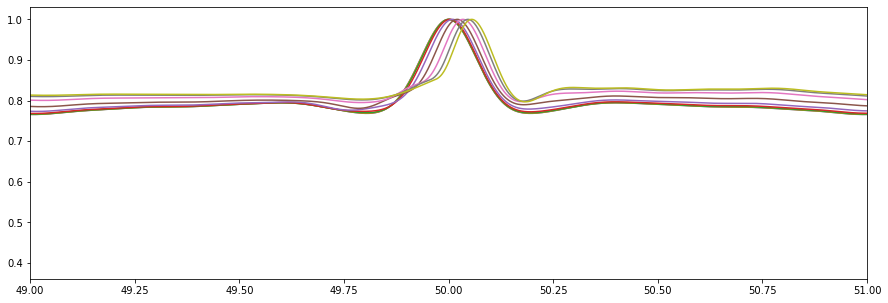

In [14]:
for L in range(len(Lum_list)):
    plt.plot(Taxis, baseXcor_list[L]/max(baseXcor_list[L]), label = str(Lum_list[L]))
plt.xlim([49, 51])
plt.gcf().set_size_inches(15, 5)

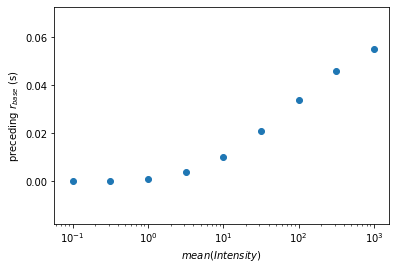

In [15]:
plt.scatter(Lum_list, b_preceding)
plt.ylabel(r'preceding $r_{base}$ (s)')
plt.xlabel(r'$mean(Intensity)$')
plt.xscale('log')

In [16]:
xXcor_list = [np.correlate(x-1, cone_list[L], 'same')/np.std(cone_list[L]) for L in range(len(Lum_list))]
# xXcor_list = [np.correlate(x-1, cone_list[L], 'same')/np.correlate(np.ones_like(x), cone_list[L], 'same') for L in range(len(Lum_list))]

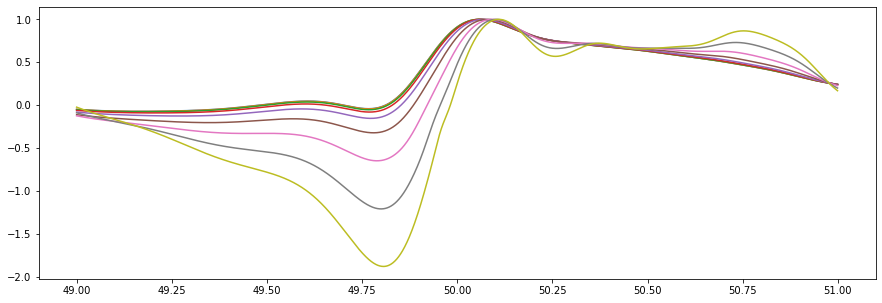

In [23]:
centerregion =  np.arange(49000, 51000)
Xc_maxidex = [np.argmin(Xcor[centerregion]) for Xcor in xXcor_list]
x_preceding = (np.array(Xc_maxidex)+centerregion[0] - autoCenter)*dt

for L in range(len(Lum_list)):
    Yinplot = xXcor_list[L][centerregion]/min(xXcor_list[L][centerregion])
    plt.plot(Taxis[centerregion], Yinplot, label = str(Lum_list[L]))
plt.gcf().set_size_inches(15, 5)

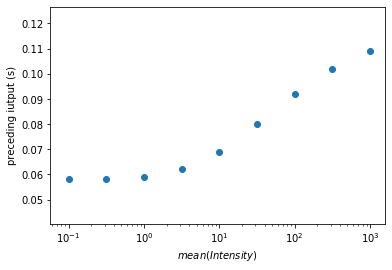

In [18]:
plt.scatter(Lum_list, x_preceding)
plt.ylabel('preceding iutput (s)')
plt.xlabel(r'$mean(Intensity)$')
plt.xscale('log')

In [19]:
b_preceding

array([0.   , 0.   , 0.001, 0.004, 0.01 , 0.021, 0.034, 0.046, 0.055])

In [20]:
x_preceding-x_preceding[0]

array([0.   , 0.   , 0.001, 0.004, 0.011, 0.022, 0.034, 0.044, 0.051])

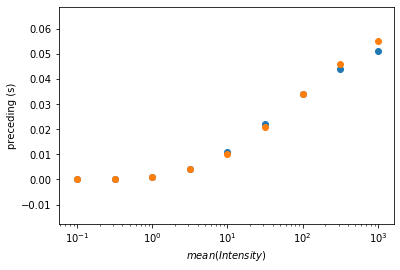

In [21]:
plt.scatter(Lum_list, x_preceding-x_preceding[0])
plt.scatter(Lum_list, b_preceding)
plt.ylabel('preceding (s)')
plt.xlabel(r'$mean(Intensity)$')
plt.xscale('log')